#### Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
import warnings; warnings.simplefilter('ignore')
pd.set_option('display.max_columns',None)
%matplotlib inline
sns.set_theme()
from code.functions import *

In [3]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

# Overview

## Contraceptive Method Choices of Married Women in Indonesia

In this project, we examine a dataset of contraceptive methods used by married Indonesian women to see what behavioral insights and predictions can be made based on various demographic and socioeconomic variables.  
  
Our aspiration is to inform sound public health policy recommendations for further action to health officials, in order to improve the welfare of mothers and children in Indonesia.  
  
We hope to have an impact in empowering healthcare autonomy of Indonesia's female citizens, while reducing unwanted pregnancy, abortion rates, birth complications, infant and maternal mortality rates.

## Dataset

### Description

This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey (NICPS), which itself was a part of the larger, annually recurrent National Socioeconomic Survey (popularly called SUSENAS). The samples are married women who were either not pregnant or do not know if they were at the time of interview.  
  
We wish to use the dataset to infer the contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics, with the goal of offering suggestions for further action to address significant social concerns such as child mortality rate, and inform the approach to public health policy and outreach.

- Number of Instances: 1473  
  - Each item in this dataset represents a married female subject of the aforementioned survey
  - Null values: None
- Number of Attributes: 10 (including the class attribute)  
  - Our target variable is `cmc` — contraceptive method used
  - A full breakdown of further attributes is listed in the table below

#### Attributes

       1. Wife's age                 | (numerical)       |
       2. Wife's education           | (categorical)     | 1=low, 2, 3, 4=high
       3. Husband's education        | (categorical)     | 1=low, 2, 3, 4=high
       4. Number of children         | (numerical)       |
       5. Wife's religion            | (binary)          | 0=Non-Islam, 1=Islam
       6. Wife's now working?        | (binary)          | 0=Yes, 1=No
       7. Husband's occupation       | (categorical)     | 1, 2, 3, 4
       8. Standard-of-living index   | (categorical)     | 1=low, 2, 3, 4=high
       9. Media exposure             | (binary)          | 0=Good, 1=Not good
                                     |                   |
           ---------------------     |     ---------     |     ------------
                                     |                   |
                                     |                   |  1=No-use  
       10. Contraceptive method used | (class attribute) |  2=Long-term Method 
                                                         |  3=Short-term Method 

#### Source

1. Origin:  
                 the 1987 National Indonesia  
               Contraceptive Prevalence Survey 
                    a subset of the annual
            National Socioeconomic Survey (SUSENAS)  

2. Creator: Tjen-Sien Lim (limt@stat.wisc.edu)  
3. Donor:   Tjen-Sien Lim (limt@stat.wisc.edu)  
4. Date:    June 7, 1997
5. Web Source: https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

#### Past Usage

Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of
   Prediction Accuracy, Complexity, and Training Time of Thirty-three
   Old and New Classification Algorithms. Machine Learning. Forthcoming.  
   (ftp://ftp.stat.wisc.edu/pub/loh/treeprogs/quest1.7/mach1317.pdf or
   (http://www.stat.wisc.edu/~limt/mach1317.pdf)

# Cleaning

The dataset comes fairly well pre-cleaned, with no null values and few outliers. We decide to cap the maximum childcount to 12 to account for low value outliers, and engineer some features below. Here we also create a dataframe that changes our multiclass target to a binary class, for use in certain visualizations and our final modelling process.

In [4]:
# Cleaning: capping maximum children down to 12
df['chil'] = np.where(df.chil > 11,
                     12,
                     df.chil)

# FE: creating a feature that represents a binary for if wife's education is higher than husband's
df['wife_more_edu'] = np.where(df.edu >= df.hus_edu,
                              1,
                              0)

# FE: creating a feature that represents a binary for women who's education level is the lowest possible while also being not employed.
df['neet'] = np.where((df.edu == 1) 
                    & (df.work == 1),
                         1,
                         0)
# here we set a binary copy of our primary df, for use wherever we want to see ...
y_df = df.copy() # ... any contraceptive use vs. no contraceptive use
y_df['uses_cm'] = np.where(y_df.cmc == 1, 
                            0, 
                            1)

The following features are categorical and will be one hot encoded in our modeling process:
- Wife's education — `edu`
- Husband's education — `hus_edu`
- Husband's ocupation — `hus_occu`
- Standard-of-living index — `sol`  
  
We will also test our models with and without dummying the feature for number of children — `chil`

# EDA

#### Initial

In [5]:
df.columns

Index(['age', 'edu', 'hus_edu', 'chil', 'rel', 'work', 'hus_ocu', 'sol',
       'media', 'cmc', 'wife_more_edu', 'neet'],
      dtype='object')

In [6]:
df.tail()

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc,wife_more_edu,neet
1468,33,4,4,2,1,0,2,4,0,3,1,0
1469,33,4,4,3,1,1,1,4,0,3,1,0
1470,39,3,3,8,1,0,1,4,0,3,1,0
1471,33,3,3,4,1,0,2,2,0,3,1,0
1472,17,3,3,1,1,1,2,4,0,3,1,0


In [7]:
df.isna().sum() # No null values

age              0
edu              0
hus_edu          0
chil             0
rel              0
work             0
hus_ocu          0
sol              0
media            0
cmc              0
wife_more_edu    0
neet             0
dtype: int64

In [8]:
df.describe()

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc,wife_more_edu,neet
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.00000
mean,32.538357,2.958588,3.429735,3.257298,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891,0.600136,0.07943
std,8.227245,1.014994,0.816349,2.340784,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376,0.490037,0.27050
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.00000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.00000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000,1.000000,0.00000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000,1.000000,0.00000
max,49.000000,4.000000,4.000000,12.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000,1.000000,1.00000


#### TARGET — Contraceptive Method Used — `cmc`

- **Note:** Long-term methods are male or female sterilization, Norplant$_1$ and IUD  
  Short-term methods are all other methods listed in the below table$_2$.  
$_1$: Levonorgestrel-releasing implant  
$_2$: All methods in survey:  
  
        Any method          |  Male sterilization  | Injection
        Pill                | Female sterilization | Diaphragm/foam/jelly 
        Periodic abstinence |       NorpLant       | Condom
        Number of children  |         IUD          | Withdrawal
        Other               |                      | 

In [9]:
df.cmc.value_counts() # values for our target. class imbalance is modest but methods of managing will be evaluated in our modeling process

1    629
3    511
2    333
Name: cmc, dtype: int64

#### Wife's Age — `age`

**Takeaways**:
- The distribution of wives who use no contraception is bimodal, with most in that category aggregating around 25 or 46.  
- The distribution of wives who report long-term contraception use centers around 35.  
- The distribution of wives who report short-term contraception use is right-skewed, with a sharp increase to the mode around age 26, then a steady, tapered decline with age.
- Setting a minimum cap where we impute values below 18 or 19 to that minimum could manage lower sample sizes.

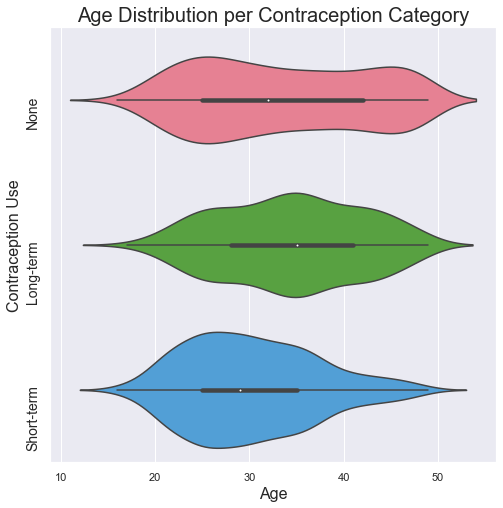

In [10]:
sns.set_palette("husl",3) 
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Age Distribution per Contraception Category', size = 20)
sns.violinplot(x= df.age, y = df.cmc, orient='h')
plt.yticks(np.arange(3), ['None', 'Long-term', 'Short-term'], size = 14, rotation = 90)
ax.set_xlabel('Age', size=16)
ax.set_ylabel('Contraception Use', size=16)
plt.show();

In [11]:
df[df.age < 21].age.value_counts()

20    28
19    18
17     8
18     7
16     3
Name: age, dtype: int64

#### Wife's Education — `edu`

Nominal integer values interpretation:
- 1 — did not go to school  
- 2 — some primary school  
- 3 — graduated from primary school with no further education  
- 4 — secondary or higher education. 

**Takeaways**:  
- With higher levels of education achieved, contraception use quite apparently becomes more prevalent.

''

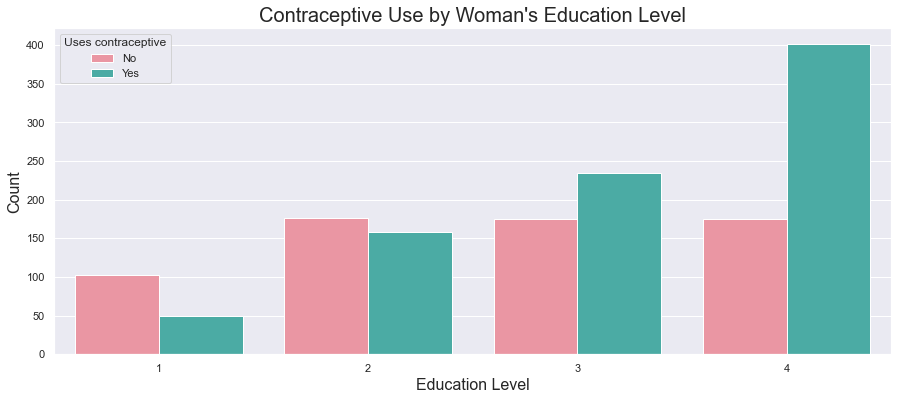

In [12]:
cm_df = df.copy()
cm_df['Uses contraceptive'] = np.where(cm_df.cmc == 1, # mapping multiclass target to a boolean Yes/No value
                            'No',
                            'Yes')

sns.set_palette('cubehelix', 1) 
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Contraceptive Use by Woman\'s Education Level', size = 20)
sns.countplot(x='edu',  hue='Uses contraceptive', data=cm_df)
ax.set_xlabel('Education Level',  size=16)
ax.set_ylabel('Count', size=16)
;

In [13]:
y_df.edu.corr(y_df['uses_cm']) # checking the correlation between education and ANY contraceptive use

0.24476553635585319

In [14]:
df.edu.value_counts()

4    577
3    410
2    334
1    152
Name: edu, dtype: int64

#### Husband's Education — `hus_edu`

Nominal integer values interpretation:
- 1 — did not go to school  
- 2 — some primary school  
- 3 — graduated from primary school with no further education  
- 4 — secondary or higher education. 

#### Number of Children — `chil`

**Takeaways**:
- The number of children that a woman has appears to have an effect on their use of contraception. Of all women with no children in the sample, *only two* use any form of contraception.
- all distributions are right-skewed
- outliers may be capped

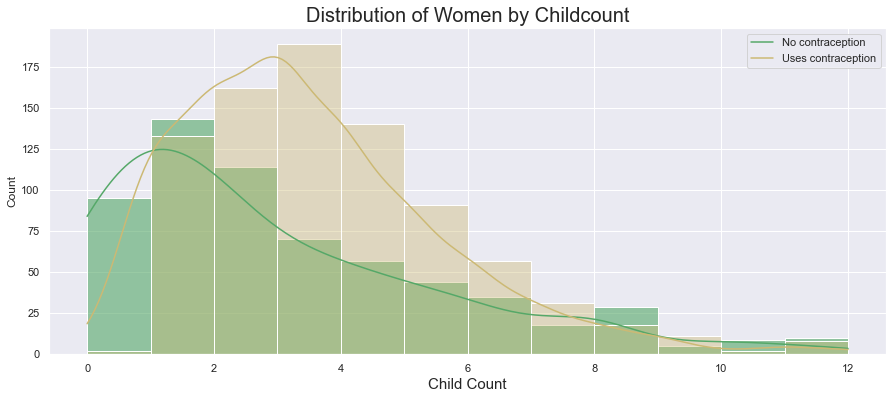

''

In [15]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Women by Childcount', size = 20)
sns.histplot(x = df[df.cmc == 1].chil, bins = 12, kde = True, color = 'g', alpha = .6)
sns.histplot(x = df[df.cmc != 1].chil, bins = 12, kde = True, color = 'y', alpha = .4)
ax.set_xlabel('Child Count', size=15)
ax.legend(labels=['No contraception', 'Uses contraception'])
plt.show()
;

In [16]:
# remarkably, of the 97 women with no children, only 2 use any form of contraception
df[df.chil == 0].cmc.value_counts()

1    95
3     2
Name: cmc, dtype: int64

In [17]:
df[(df.chil == 0) & (df.cmc != 1)] 

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc,wife_more_edu,neet
942,17,2,2,0,1,0,3,2,0,3,1,0
1443,21,2,2,0,0,1,4,4,0,3,1,0


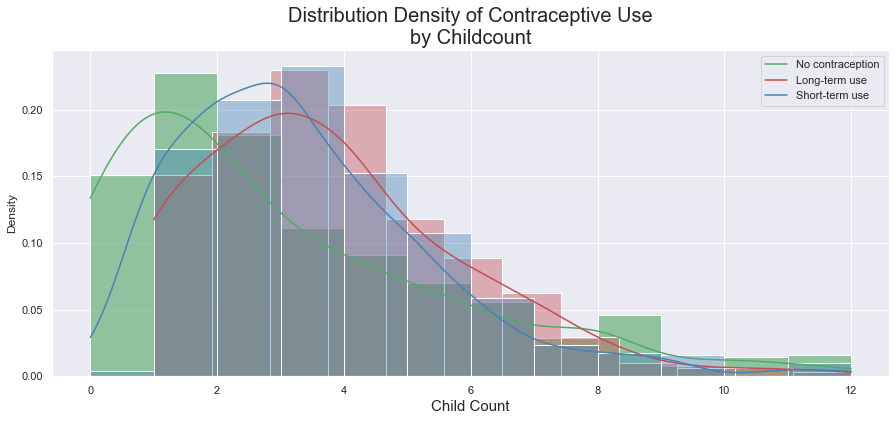

''

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution Density of Contraceptive Use\nby Childcount', size = 20)
sns.histplot(x = df[df.cmc == 1].chil, bins = 12, kde = True, stat = 'density', color = 'g', alpha = .6)
sns.histplot(x = df[df.cmc == 2].chil, bins = 12, kde = True, stat = 'density', color = 'r', alpha = .4)
sns.histplot(x = df[df.cmc == 3].chil, bins = 12, kde = True, stat = 'density', color = 'steelblue', alpha = .4)
ax.set_xlabel('Child Count', size=15)
ax.legend(labels=['No contraception', 'Long-term use', 'Short-term use'])
plt.show()
;

In [19]:
df[df.chil > 9].chil.value_counts() # low value counts for higher child counds even after dummying

10    11
11    11
12     7
Name: chil, dtype: int64

#### Wife's Religion — `rel`

- 1 = Islam
- 0 = Non-Islam

**Takeaways**:
- The distribution of wives by age is more normally distributed for non-Muslim women than Muslim women for the respective classes of contraceptive method, despite having lower value counts.
- The central tendancy for Muslim women who use short-term contraceptive methods is younger amongst Muslim woman than it is for non-Muslim.
- The number of wives in the sample who are Muslim outnumber those that are not by roughly: 6:1

In [20]:
df[df.chil > 9 ].cmc.values # checking the use of contraception among women with a higher range of children

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3])

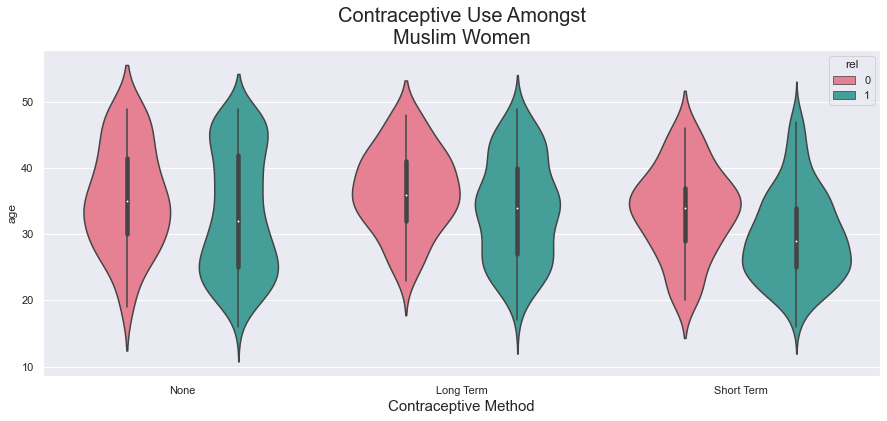

In [21]:
sns.set_palette("husl",2) 
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Contraceptive Use Amongst\nMuslim Women', size = 20)
sns.violinplot(x = df.cmc, y = df.age, orient = 'v',
               hue = df.rel, scale_hue = False)
plt.xticks(np.arange(3), ['None', 'Long Term', 'Short Term'])
ax.set_xlabel('Contraceptive Method', size=15)
plt.show();

In [22]:
df[df.rel == 1].cmc.value_counts() # value counts for contraceptive method classes among Muslim women

1    554
3    442
2    257
Name: cmc, dtype: int64

In [23]:
df.rel.value_counts() # class imbalance of roughly 6:1 Muslim to non-Muslim

1    1253
0     220
Name: rel, dtype: int64

#### Wife's Current Employment Status — `work`

- 1 — No
- 0 — Yes

**Takeaways**:
- binary categorical
- Class Imbalanced of roughly: 3:1, not employed to employed

''

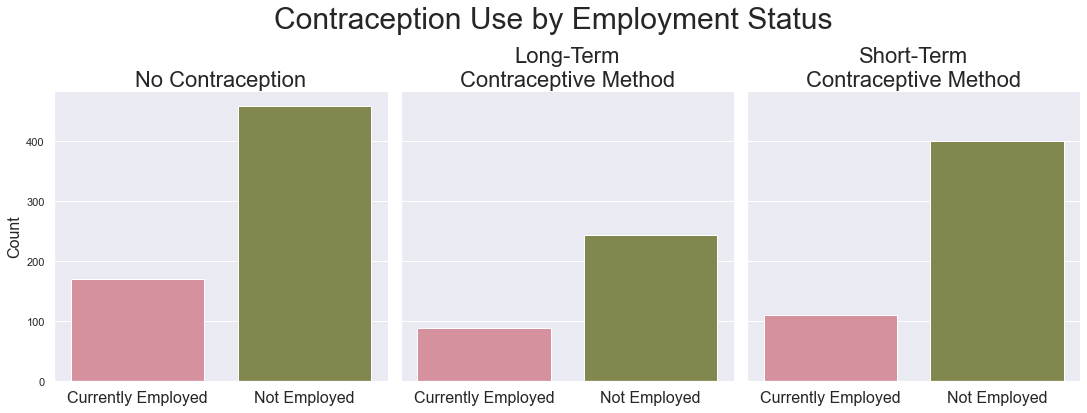

In [24]:
sns.set_palette("husl",4) 
df_work_copy = df.copy() # We make a copy of the original dataframe for unique categorical plots
df_work_copy['cmc'] = df_work_copy['cmc'].map({ # Here we map the nominal integers to a string of their respective categorical interpretation
    1: "No Contraception", 
    2: "Long-Term\nContraceptive Method", 
    3: "Short-Term\nContraceptive Method"})

g = sns.catplot(x="work", col="cmc", col_wrap=3, # plotting distributions for different groups of women's employment status, with separate plots representing woman of the three classes of contraceptive method 
            data=df_work_copy, saturation=.5,
            kind="count", height=5, aspect=1)
(g.set_axis_labels("", "Count", size=16)
  .set_xticklabels(['Currently Employed', 'Not Employed'], size=16)
  .set_titles('{col_name}', size=22)
  .fig.suptitle('Contraception Use by Employment Status', size = 30, y=1.13)
)
;

#### Husband's Occupation — `hus_ocu`

- 1 — PROFESSIONAL, TECHNICAL AND CLERICAL
- 2 — SALES, SERVICES
- 3 — MANUAL 
- 4 — AGRICULTURE
- 5 — OTHER

**Takeaways**:
- Numerical values for this category are in fact **categorical** and are to be dummied. 
  - The values from the dataset range from 1-4, **however,** the dataset description numbers range from 1-5.
  - While it is confusing as to which number truly represents which category in our dataset (as we are missing one number listed in the survey description), there is no need to impute.  
  - Unfortunately, uncertainty about which category of occupation each nominal integer represents will make it difficult to offer suggestions for further action relating to this category.

#### Standard-of-living Index — `sol`

- Standard-of-living index ranging from 1 (low) to 4 (high).
- Referencing the dataset description text file doesn't allow insight for interpreting what these values qualitatively represent, and unfortunately there is no futher information about the standard-of-living index referenced in any of the reports for the surveys.
- Short-term contraceptive methods seem to be more preferable or accessible than long-term contraceptive methods for people who rate lower on the standard of living index.

''

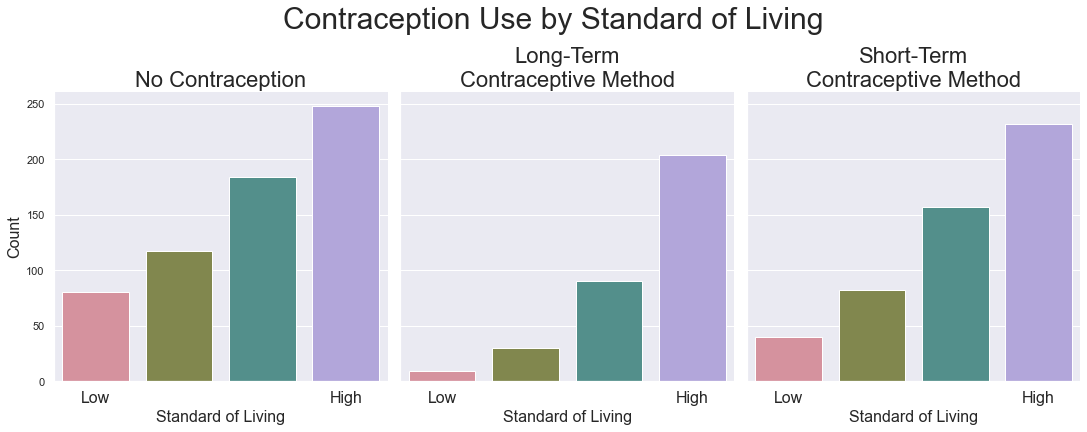

In [25]:
sns.set_palette("husl",4) 
df_sol_copy = df.copy() # We make a copy of the original dataframe for unique categorical plots
df_sol_copy['cmc'] = df_sol_copy['cmc'].map({ # Here we map the nominal integers to a string of their respective categorical interpretation
    1: "No Contraception", 
    2: "Long-Term\nContraceptive Method", 
    3: "Short-Term\nContraceptive Method"})

g = sns.catplot(x = 'sol', col = 'cmc', col_wrap = 3, # plotting distributions grouped by standard of living, with separate plots representing woman of the three classes of contraceptive method 
            data = df_sol_copy, saturation=.5,
            kind = 'count', height=5, aspect=1)
(g.set_axis_labels('Standard of Living', 'Count', size=16)
  .set_xticklabels(['Low', '', '', 'High'], size=16)
  .set_titles('{col_name}', size=22)
  .fig.suptitle('Contraception Use by Standard of Living', size = 30, y=1.13)
)
;

#### Media Exposure —`media`

- According to the survey, the qualifiers for having "good" media exposure is as follows: 

      Ever-married women who usually read a newspaper once a week, watch television once a week, or listen to a radio daily by background characteristics — NICPS, 1987  
  
- 0 — Good
- 1 — Not good  
  
**Takeaways**:
- Binary categorical. 
- Class imbalance of about: 13:1, good media exposure to not good
  - A great majority of women in this survey have good media exposure. 

''

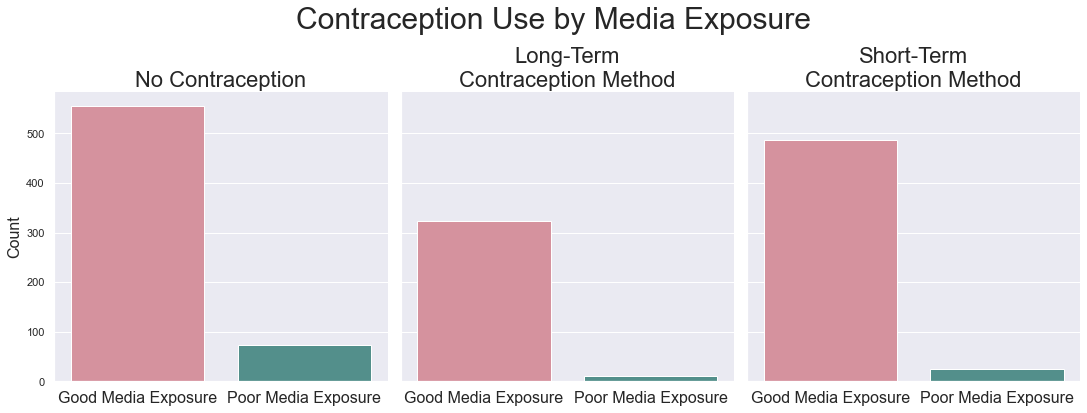

In [26]:
sns.set_palette("husl",2) 
df_media_copy = df.copy() # We make a copy of the original dataframe for unique categorical plots
df_media_copy['cmc'] = df_media_copy['cmc'].map({ # Here we map the nominal integers to a string of their respective categorical interpretation
    1: "No Contraception", 
    2: "Long-Term\nContraception Method", 
    3: "Short-Term\nContraception Method"})

g = sns.catplot(x="media", col="cmc", col_wrap=3, # plotting distributions grouped by media exposure, with separate plots representing woman of the three classes of contraceptive method 
            data=df_media_copy, saturation=.5,
            kind="count", height=5, aspect=1)
(g.set_axis_labels("", "Count", size=16)
  .set_xticklabels(['Good Media Exposure', 'Poor Media Exposure'], size=16)
  .set_titles('{col_name}', size=22)
  .fig.suptitle('Contraception Use by Media Exposure', size = 30, y=1.13)
)
;

In [27]:
df.media.value_counts()

0    1364
1     109
Name: media, dtype: int64

## Further Research

After submitting an application, we have received authorization from [the Demographic and Health Surveys program (DHS)](https://www.dhsprogram.com/Countries/Country-Main.cfm?ctry_id=17&c=Indonesia&Country=Indonesia&cn=&r=4) to access the original NICPS full datasets, which includes more attributes and a much larger sample size. 
  
The original datasets will allow to find deeper insights, as well as test our model on the population of Indonesia in subsequent years.  
  
We would like to see what other targets may be predicted on to make further public health policy suggestions.

# Feature Engineering

From the attributes present in the sample dataset, we have created the following features:
- `wife_more_edu` — Engineered from `edu` and `hus_edu`, reprents if the wife's education level is at least as high as the husband's.
- `neet` — Engineered from `edu` and `work` (acronym borrowed from '*not educated, employed or in training*', though we are not certain if the training part happens to be the case in this instance).

In [28]:
df.wife_more_edu.value_counts()

1    884
0    589
Name: wife_more_edu, dtype: int64

In [29]:
df.neet.value_counts()

0    1356
1     117
Name: neet, dtype: int64

# Modeling

### Data Preparation

- We first separate our **target** `cmc` from our **predictor** variables 
- We then manage categorical features that are not binary with **One Hot Encoding / Dummying**

In [30]:
# We use our binary target dataframe for our final model, and drop the original multiclass target column
y_df.drop('cmc', axis=1, inplace=True)

In [31]:
# Separating target and prectors in to their respective variables
X = df.drop('cmc', axis=1, inplace=False)
y = y_df['uses_cm']

### Dummying, Train Test Split, & Scaling

We dummy our categorical variables, split our dataset in to a training dataset and a testing dataset, and scale our features with  
our custom function `dummy_transform_scale()`.

In [32]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']

In [33]:
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(X, y, to_dummy, rs = 729)

## Fitting & Hyperparameter Tuning

We implement our `model_stats()` function throughout our modeling process for model evaluation and to inform us  
of which hyperparameters tuning are producing the best model.

Below are our best performing models; all models tested are in our `model_fitting_and_tuning.ipynb` notebook.

### Logistic Regression with Grid Search Cross Validation

We create a pipeline for our logistic regression algorithm, and perform a grid search cross validation, which will return a model  
with optimum hyperparameter tuning, based on the set of hyperparameters we input.

In [34]:
# Creating logistic regression pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=729, max_iter = 500))])

# Creating variable of set of hyperparameters
params_grid_lr = {'lr__penalty' : ['l1', 'l2'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['lbfgs', 'liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20)
                 }

{'lr__C': 29.763514416313132, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  30
Model score:  0.7452574525745257
Accuracy score:  0.7452574525745257
Model F1 (micro):  0.7452574525745256
Model F1 (macro):  0.7348813745872569
Model F1 (weighted):  0.7449731764652854
Cross validation score:  [0.63513514 0.71621622 0.75675676 0.63513514 0.68493151]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       149
           1       0.78      0.79      0.79       220

    accuracy                           0.75       369
   macro avg       0.74      0.73      0.73       369
weighted avg       0.74      0.75      0.74       369



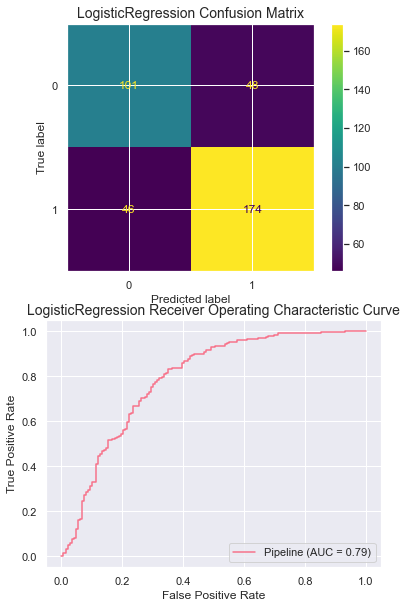

In [35]:
# Instantiating GridSearchCV object based on our set of hyperparameters for logistic regression
lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1, scoring='recall')

# Fitting our training data to our Logistic Regression grid search-CV object
lr_clf.fit(X_train, y_train)

# Printing the resulting best hyperparameters, best estimator, and our model stats
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_dums.columns, best_lr_clf, 'LogisticRegression', X_test, y_test, True)

### LogisticRegression GridSearchCV with Tomek Links Resampling

We can evaluate Logistic Regression applied to our data further with use of Tomek Links as an alternative method of class balancing.

In [54]:
# Instantiating TomekLinks object
tl = TomekLinks()

# Reshaping predictors and target training datasets for Tomek Links
X_res, y_res = tl.fit_resample(X_train, y_train.ravel())
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 519, 0: 480})


## RandomForestClassifier GridSearchCV

{'rfc__max_depth': 6, 'rfc__max_features': 'auto', 'rfc__n_estimators': 70}
Classifier:  RandomForestClassifier
Num features:  30
Model score:  0.6856368563685636
Accuracy score:  0.6856368563685636
Model F1 (micro):  0.6856368563685636
Model F1 (macro):  0.651818832563285
Model F1 (weighted):  0.672697786390892
Cross validation score:  [0.64864865 0.68918919 0.64864865 0.60810811 0.60273973]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.46      0.54       149
           1       0.70      0.84      0.76       220

    accuracy                           0.69       369
   macro avg       0.68      0.65      0.65       369
weighted avg       0.68      0.69      0.67       369



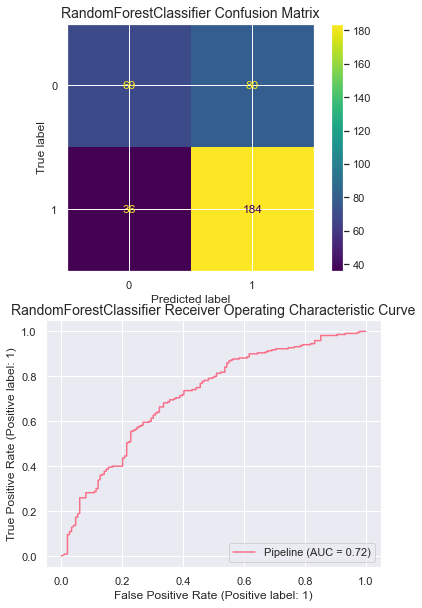

In [59]:
# Creating logistic regression pipeline
pipe_rfc = Pipeline([('rfc' , RandomForestClassifier())])

# Creating variable of set of hyperparameters
params_grid_rfc = {'rfc__n_estimators' : list(range(10,101,10)),
                   'rfc__max_features': ['auto', 'sqrt', 'log2'],
                   'rfc__max_depth' : list(range(1,10))
                  }

# Instantiating GridSearchCV object based on our set of hyperparameters for Random Forests
rfc_clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

# Fitting our training data to our Random Forests grid search-CV object
rfc_clf.fit(X_train, y_train)

# Printing the resulting best hyperparameters, best estimator, and our model stats
print(rfc_clf.best_params_)
best_rfc_clf = rfc_clf.best_estimator_
model_stats(X_dums.columns, best_rfc_clf, 'RandomForestClassifier', X_test, y_test, True)

### RandomForestClassifier GridSearchCV with Tomek Links resampling

As we did with our logistic regression model, we can run our model with Tomek Links resampling as a method of managing  
class imbalance and compare which instance performs the best for our evaluation metric.

{'rfc__max_depth': 9, 'rfc__max_features': 'auto', 'rfc__n_estimators': 80}
Classifier:  RandomForestClassifier
Num features:  30
Model score:  0.6341463414634146
Accuracy score:  0.6341463414634146
Model F1 (micro):  0.6341463414634146
Model F1 (macro):  0.6306306306306306
Model F1 (weighted):  0.6375643936619546
Cross validation score:  [0.67567568 0.63513514 0.7027027  0.66216216 0.54794521]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.66      0.59       149
           1       0.73      0.61      0.67       220

    accuracy                           0.63       369
   macro avg       0.63      0.64      0.63       369
weighted avg       0.65      0.63      0.64       369



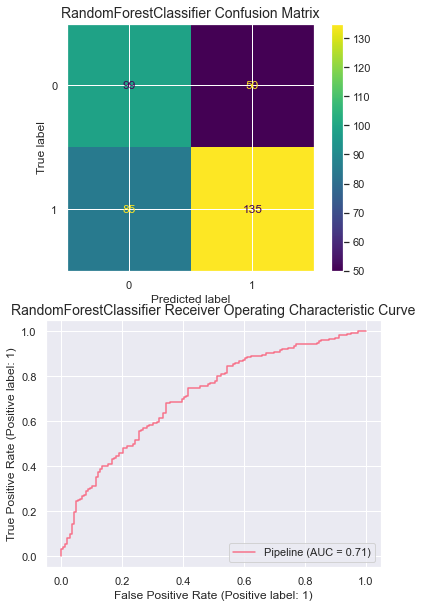

In [61]:
# Instantiating Grid Search object
rfc_tl_clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

# Fitting on our data
rfc_tl_clf.fit(X_res, y_res)
print(rfc_tl_clf.best_params_)
best_rfc_tl_clf = rfc_tl_clf.best_estimator_
model_stats(X_dums.columns, best_rfc_tl_clf, 'RandomForestClassifier', X_test, y_test, True)

## XGBoost with GridSearchCV

Classifier:  XGBClassifier
Num features:  30
Model score:  0.7073170731707317
Accuracy score:  0.7073170731707317
Model F1 (micro):  0.7073170731707317
Model F1 (macro):  0.6925
Model F1 (weighted):  0.7054878048780487
Cross validation score:  [0.68918919 0.66216216 0.64864865 0.64864865 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       149
           1       0.74      0.78      0.76       220

    accuracy                           0.71       369
   macro avg       0.70      0.69      0.69       369
weighted avg       0.70      0.71      0.71       369



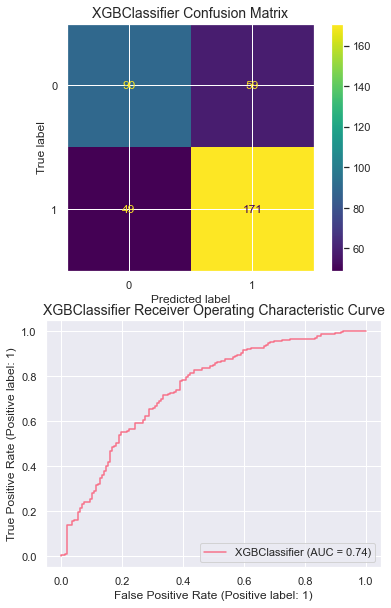

In [62]:
xgb = XGBClassifier(random_state=729, learning_rate = 0.2, eval_metric = 'auc')
xgb.fit(X_train, y_train)
model_stats(X_dums.columns, xgb, 'XGBClassifier', X_test, y_test, True)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[13:29:40] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'xgb__booster': 'gblinear', 'xgb__colsample_bylevel': 0.5, 'xgb__colsample_bynode': 0.5, 'xgb__colsample_bytree': 0.5, 'xgb__max_depth': 8, 'xgb__min_child_weight': 7, 'xgb__missing': -999, 'xgb__n_estimators': 250, 'xgb__nthread': 4, 'xgb__subsample': 0.2}
Classifier:  XGBClassifier
Num features:  30
Model score:  0.7588075880758808
Accuracy score:  0.7588075880758808
Model F1 (micro):  0.7588075880758808
Model F1 (macro):  0.7388535031847134
Model F1 (weighted):  0.7527431112952319
[13:29:40] WARNING: ../src/learner

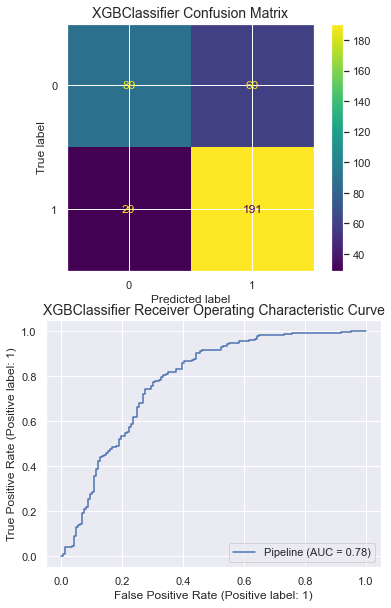

In [67]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729, learning_rate = 0.2, eval_metric = 'auc'))])
params_grid_xgb = {'xgb__nthread': [4],
                   'xgb__booster' : ['gbtree', 'gblinear', 'dart'],
                   'xgb__colsample_bylevel': [0.5, 0.75],
                   'xgb__colsample_bynode': [0.5, 0.75],
                   'xgb__colsample_bytree': [0.5, 0.75],
                   'xgb__max_depth': [8, 10],
                   'xgb__min_child_weight': [7, 9],
                   'xgb__missing': [-999],
                   'xgb__n_estimators': [250],
                   'xgb__subsample': [0.2, 0.5, 0.7]
                  }
xgb_clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=3, shuffle=True), 
                  scoring='f1_weighted',
                  verbose=2, refit=True)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.best_params_)
best_xgb_clf = xgb_clf.best_estimator_
model_stats(X_dums.columns, best_xgb_clf, 'XGBClassifier', X_test, y_test, True)

### Again with Hyperparameter Tuning

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[13:38:40] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'xgb__booster': 'gblinear', 'xgb__colsample_bylevel': 0.25, 'xgb__colsample_bynode': 0.25, 'xgb__colsample_bytree': 0.25, 'xgb__max_depth': 6, 'xgb__min_child_weight': 5, 'xgb__missing': -999, 'xgb__n_estimators': 250, 'xgb__nthread': 4, 'xgb__subsample': 0.1}
Classifier:  XGBClassifier
Num features:  30
Model score:  0.7588075880758808
Accuracy score:  0.7588075880758808
Model F1 (micro):  0.7588075880758808
Model F1 (macro):  0.7388535031847134
Model F1 (weighted):  0.7527431112952319
[13:38:40] WARNING: ../src/le

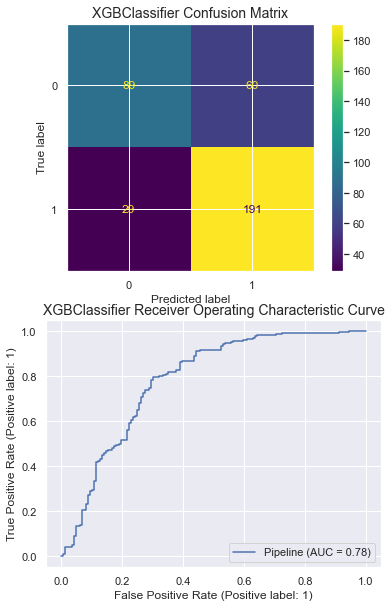

In [68]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729, learning_rate = 0.3, eval_metric = 'auc'))])
params_grid_xgb = {'xgb__nthread': [4],
                   'xgb__booster' : ['gbtree', 'gblinear', 'dart'],
                   'xgb__colsample_bylevel': [0.25, 0.4, 0.5],
                   'xgb__colsample_bynode': [0.25, 0.4, 0.75],
                   'xgb__colsample_bytree': [0.25, 0.4, 0.75],
                   'xgb__max_depth': [6, 7, 8], # Also tested with 7, 8, 10
                   'xgb__min_child_weight': [5, 6, 7], # Also tested with 5, 6, 7, 9
                   'xgb__missing': [-999],
                   'xgb__n_estimators': [250],
                   'xgb__subsample': [0.1, 0.15, 0.2] # Also tested with 0.15, 0.2, 0.5, 0.7
                  }
xgb_clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=3, shuffle=True), 
                  scoring='f1_weighted',
                  verbose=2, refit=True)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.best_params_)
best_xgb_clf = xgb_clf.best_estimator_
model_stats(X_dums.columns, best_xgb_clf, 'XGBClassifier', X_test, y_test, True)

### Using optimal hyperparamters, optimize for recall

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[13:38:42] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'xgb__booster': 'gblinear', 'xgb__colsample_bylevel': 0.25, 'xgb__colsample_bynode': 0.25, 'xgb__colsample_bytree': 0.25, 'xgb__max_depth': 5, 'xgb__min_child_weight': 4, 'xgb__missing': -999, 'xgb__n_estimators': 250, 'xgb__nthread': 4, 'xgb__subsample': 0.05}
Classifier:  XGBClassifier
Num features:  30
Model score:  0.7588075880758808
Accuracy score:  0.7588075880758808
Model F1 (micro):  0.7588075880758808
Model F1 (macro):  0.7388535031847134
Model F1 (weighted):  0.7527431112952319
[13:38:42] WARNING: ../src/learne

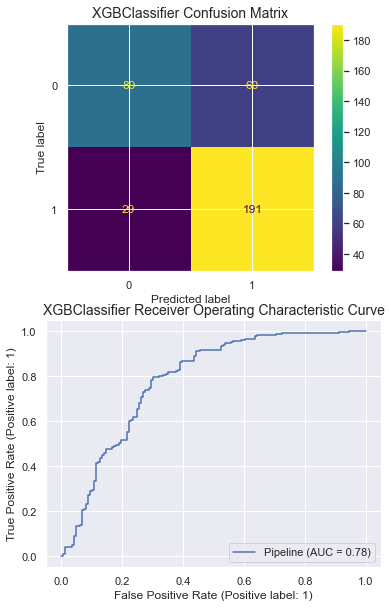

In [69]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729, learning_rate = 0.3, eval_metric = 'auc'))])
params_grid_xgb = {'xgb__nthread': [4],
                   'xgb__booster' : ['gblinear'],
                   'xgb__colsample_bylevel': [0.25],
                   'xgb__colsample_bynode': [0.25],
                   'xgb__colsample_bytree': [0.25],
                   'xgb__max_depth': [5, 6], # Also tested with 7, 8, 10
                   'xgb__min_child_weight': [4, 5], # Also tested with 5, 6, 7, 9
                   'xgb__missing': [-999],
                   'xgb__n_estimators': [250],
                   'xgb__subsample': [0.05, 0.1] # Also tested with 0.15, 0.2, 0.5, 0.7
                  }
xgb_clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=3, shuffle=True), 
                  scoring='recall',
                  verbose=2, refit=True)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.best_params_)
best_xgb_clf = xgb_clf.best_estimator_
model_stats(X_dums.columns, best_xgb_clf, 'XGBClassifier', X_test, y_test, True)

# Conclusion

After running model feature selection, it appears that age and number of children are a strong indicator for a woman’s use of contraception.

Ultimately our XGBClassifier model with GridSearch cross validation resulted in the best recall and accuracy, our primary evaluation metrics.  
Logistic Regression came in a close second.

Our best model performed with and average recall of .75, F1 score of .74, and ROC-AUC of .79.

The model also suggests that a woman’s education is a strong indicator of the likelihood for her to select a long-term contraceptive method.

It would be beneficial to direct public health initiative around these factors.